# Lab 5: Edge Computing Simulation with Lightweight Framework

In [1]:
"""
Edge Computing Simulation: Model Optimization and Deployment
Demonstrates model compression techniques for edge devices
"""
# --- Imports: we pull in everything we need for data, modeling, and charts ---
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [3]:
# We turn off the GPU to imitate a tiny edge device (like a small box or sensor)
# that does not have powerful hardware. This helps us see realistic speeds.
tf.config.set_visible_devices([], 'GPU')

## PART 1: Generate Dataset (IoT Sensor Classification)

In [4]:
print("\n" + "="*70)
print("GENERATING IOT SENSOR DATASET")
print("="*70)


GENERATING IOT SENSOR DATASET


In [5]:
# Create a synthetic dataset:
# - n_samples: how many rows of data we want (10,000 examples)
# - n_features: number of sensor measurements per example (20)
# - n_informative: features that truly matter to the prediction (15)
# - n_redundant: features that are combinations of the informative ones (5)
# - n_classes: number of possible device states (3)
# - random_state: fixed seed so you can reproduce the same results
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=3,
    random_state=42
)

In [6]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
# Show basic info so we know the size and shape of our data
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {len(np.unique(y))}")

Training samples: 8000
Test samples: 2000
Features: 20
Classes: 3


## PART 2: Create Baseline Model (Cloud Model)

In [8]:
print("\n" + "="*70)
print("TRAINING BASELINE (CLOUD) MODEL")
print("="*70)


TRAINING BASELINE (CLOUD) MODEL


In [9]:
def create_baseline_model(input_shape, num_classes):
    """Build a larger neural network (our 'cloud' model) to get top accuracy.
    - Dense layers are like stacked filters that learn patterns in the data.
    - Dropout randomly turns off some connections during training to reduce
      overfitting (helps the model generalize better to new data).
    - The final layer uses 'softmax' to output probabilities for each class.
    """
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [10]:
# Create and compile the baseline model:
# - optimizer='adam' decides how the model updates its weights as it learns
# - loss='sparse_categorical_crossentropy' measures how wrong the predictions are
# - metrics=['accuracy'] tells Keras to track accuracy during training
baseline_model = create_baseline_model(X_train.shape[1], len(np.unique(y)))
baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
print("\nBaseline Model Architecture:")
baseline_model.summary()


Baseline Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,123 (51.26 KB)

 Trainable params: 13,123 (51.26 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the baseline model:
# - validation_split=0.2 keeps 20% of the training data for validation
#   (used to monitor overfitting as training progresses)
# - epochs=20 means the model sees the data 20 times
# - batch_size=32 controls how many samples are processed at once
# - verbose=0 hides the per-epoch logs to keep the output clean
history = baseline_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=0
)

In [13]:
baseline_accuracy = baseline_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"\nBaseline Model Accuracy: {baseline_accuracy:.4f}")


Baseline Model Accuracy: 0.9335


## PART 3: Model Compression Techniques

In [14]:
print("\n" + "="*70)
print("APPLYING MODEL COMPRESSION TECHNIQUES")
print("="*70)


APPLYING MODEL COMPRESSION TECHNIQUES


In [15]:
# Technique 1: Pruning (simplify the model structure)
# Idea: Use a smaller network (fewer neurons/parameters) to reduce size and cost.
# Note: This example reduces layer sizes directly (a simple form of pruning).
def create_pruned_model(input_shape, num_classes, sparsity=0.5):
    """Create a smaller network by using fewer neurons in each layer.
    This reduces memory and compute needs and often runs faster on edge devices.
    """
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(64, activation='relu'),  # Reduced from 128 in baseline
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),  # Reduced from 64 in baseline
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [16]:
pruned_model = create_pruned_model(X_train.shape[1], len(np.unique(y)))
pruned_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
print("\n1. PRUNED MODEL")
print("-" * 70)


1. PRUNED MODEL
----------------------------------------------------------------------


In [18]:
# Train the smaller model and check how much accuracy we keep
pruned_model.fit(X_train, y_train, validation_split=0.2,
                 epochs=20, batch_size=32, verbose=0)
pruned_accuracy = pruned_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Pruned Model Accuracy: {pruned_accuracy:.4f}")

Pruned Model Accuracy: 0.9285


In [19]:
# Technique 2: Quantization (use smaller number types)
# Idea: Convert 32-bit numbers to 8-bit integers (INT8) to shrink size and
# speed up inference on devices that support it (like microcontrollers/NPUs).
print("\n2. QUANTIZED MODEL (INT8)")
print("-" * 70)


2. QUANTIZED MODEL (INT8)
----------------------------------------------------------------------


In [20]:
# Convert the baseline Keras model to a compact TFLite model with INT8 weights
converter = tf.lite.TFLiteConverter.from_keras_model(baseline_model)

In [21]:
# Tell the converter we want it to aggressively shrink/optimize the model
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [22]:
# Representative dataset: a small sample of real inputs that helps TFLite learn
# how to scale and shift values correctly when converting to INT8. Without this,
# accuracy can drop significantly.
def representative_dataset():
    for i in range(100):
        # TFLite expects float32 here; it will analyze value ranges for scaling
        yield [X_train[i:i+1].astype(np.float32)]

In [23]:
converter.representative_dataset = representative_dataset

In [24]:
# Force full INT8 quantization for both ops and I/O tensors if possible
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

In [25]:
# Perform the conversion to a TFLite byte string
quantized_tflite_model = converter.convert()

Saved artifact at '/tmp/tmp1sboow59'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  139565393912528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139565393913680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139565393913296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139565393914832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139565393913104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139565393915216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139565393915984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139565393914448: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [26]:
# Save the tiny flatbuffer model to disk so it could be deployed to a device
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

In [27]:
# Load the TFLite model into an interpreter that can run it locally
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [28]:
# We need references to read/write tensors (inputs/outputs) by index
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [29]:
# Run predictions with the quantized model:
# We must convert each input example to INT8 with the right scale/zero-point.
quantized_predictions = []
for x in X_test:
    # Quantize input:
    # - 'scale' and 'zero_point' define how float values map to INT8 [-128,127]
    input_scale, input_zero_point = input_details[0]['quantization']
    x_quantized = (x / input_scale + input_zero_point).astype(np.int8)

    # Set the input tensor and run the model
    interpreter.set_tensor(input_details[0]['index'], [x_quantized])
    interpreter.invoke()

    # Dequantize output back to float to interpret probabilities
    output = interpreter.get_tensor(output_details[0]['index'])
    output_scale, output_zero_point = output_details[0]['quantization']
    output_dequantized = (output.astype(np.float32) - output_zero_point) * output_scale

    # Choose the class with the highest predicted probability
    quantized_predictions.append(np.argmax(output_dequantized))

In [30]:
# Measure accuracy of the quantized model
quantized_accuracy = accuracy_score(y_test, quantized_predictions)
print(f"Quantized Model Accuracy: {quantized_accuracy:.4f}")

Quantized Model Accuracy: 0.9240


In [31]:
# Technique 3: Knowledge Distillation
# Idea: Train a smaller "student" model to imitate the "teacher" (baseline).
# The teacher's softer probability outputs guide the student to learn more
# efficiently than training on hard labels alone.
print("\n3. DISTILLED MODEL (Student Learning from Teacher)")
print("-" * 70)


3. DISTILLED MODEL (Student Learning from Teacher)
----------------------------------------------------------------------


In [32]:
def create_student_model(input_shape, num_classes):
    """A smaller network that aims to copy the teacher's behavior."""
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [33]:
student_model = create_student_model(X_train.shape[1], len(np.unique(y)))

In [34]:
# Temperature controls how "soft" the teacher's probabilities are.
# Higher temperature spreads probability mass across classes (easier to learn).
temperature = 3.0

In [35]:
def distillation_loss(y_true, y_pred, teacher_pred, temperature=3.0, alpha=0.5):
    """Custom loss to blend true labels and teacher guidance.
    - student_loss: standard loss comparing student to true labels.
    - distill_loss: compares student to teacher's softened probabilities.
    - alpha: how much we trust the true labels vs the teacher's guidance.
    Note: We define it for clarity, but below we fit with the standard loss.
    """
    # Student loss with true labels
    student_loss = keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # Distillation loss comparing soft distributions
    teacher_soft = tf.nn.softmax(teacher_pred / temperature)
    student_soft = tf.nn.softmax(y_pred / temperature)
    distill_loss = tf.reduce_mean(
        keras.losses.categorical_crossentropy(teacher_soft, student_soft)
    ) * (temperature ** 2)

    return alpha * student_loss + (1 - alpha) * distill_loss

In [36]:
# Get teacher (baseline) predictions on the training set.
# In a full distillation setup, we would combine these with the custom loss.
teacher_predictions = baseline_model.predict(X_train, verbose=0)

In [37]:
# Here we train the student with standard supervised learning for simplicity.
# (This still demonstrates the "smaller model" concept.)
student_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
student_model.fit(X_train, y_train, epochs=20, batch_size=32,
                  validation_split=0.2, verbose=0)

In [38]:
# Evaluate the smaller student on the held-out test set
distilled_accuracy = student_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Distilled Model Accuracy: {distilled_accuracy:.4f}")

Distilled Model Accuracy: 0.9130


## PART 4: Edge Inference Simulation

In [39]:
print("\n" + "="*70)
print("EDGE INFERENCE SIMULATION")
print("="*70)


EDGE INFERENCE SIMULATION


In [40]:
def measure_inference_time(model, data, n_runs=100):
    """Measure average time (in milliseconds) to make one prediction.
    We run the same single-sample prediction many times and average it to
    smooth out any timing noise.
    """
    times = []
    for _ in range(n_runs):
        start = time.time()
        _ = model.predict(data[:1], verbose=0)  # predict on one sample
        times.append(time.time() - start)
    return np.mean(times) * 1000  # seconds -> milliseconds

In [41]:
def get_model_size(model):
    """Estimate model size in kilobytes (KB).
    We count the number of trainable parameters and assume each is a 32-bit
    float (4 bytes). This gives a rough memory footprint of the weights only.
    """
    total_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    return total_params * 4 / 1024  # 4 bytes per float32, then convert to KB

In [42]:
# Gather metrics for the Keras models (baseline, pruned, distilled)
models = {
    'Baseline (Cloud)': baseline_model,
    'Pruned': pruned_model,
    'Distilled': student_model
}

In [43]:
results = []
for name, model in models.items():
    # How fast is a single prediction?
    inference_time = measure_inference_time(model, X_test)
    # Rough size in KB based on parameter count
    model_size = get_model_size(model)
    # Test accuracy for fairness
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    # Exact number of trainable parameters
    params = model.count_params()

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Inference Time (ms)': inference_time,
        'Size (KB)': model_size,
        'Parameters': params
    })
    # Print an easy-to-read summary for this model
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Inference Time: {inference_time:.3f} ms")
    print(f"  Model Size: {model_size:.2f} KB")
    print(f"  Parameters: {params:,}")


Baseline (Cloud):
  Accuracy: 0.9335
  Inference Time: 96.886 ms
  Model Size: 51.26 KB
  Parameters: 13,123

Pruned:
  Accuracy: 0.9285
  Inference Time: 96.692 ms
  Model Size: 13.76 KB
  Parameters: 3,523

Distilled:
  Accuracy: 0.9130
  Inference Time: 97.254 ms
  Model Size: 4.89 KB
  Parameters: 1,251


In [44]:
# Add quantized model metrics:
# - Size comes directly from the TFLite file length
# - Inference time is just a simple placeholder estimate here
quantized_size = len(quantized_tflite_model) / 1024
results.append({
    'Model': 'Quantized (INT8)',
    'Accuracy': quantized_accuracy,
    'Inference Time (ms)': 0.5,  # Estimated placeholder for illustration
    'Size (KB)': quantized_size,
    'Parameters': baseline_model.count_params()
})

In [45]:
print(f"\nQuantized (INT8):")
print(f"  Accuracy: {quantized_accuracy:.4f}")
print(f"  Model Size: {quantized_size:.2f} KB")


Quantized (INT8):
  Accuracy: 0.9240
  Model Size: 21.63 KB


## PART 5: Visualization and Comparison

In [46]:
print("\n" + "="*70)
print("GENERATING COMPARISON VISUALIZATIONS")
print("="*70)


GENERATING COMPARISON VISUALIZATIONS


In [47]:
# Put all results into a DataFrame for easy plotting and printing
results_df = pd.DataFrame(results)
print("\n", results_df.to_string(index=False))


            Model  Accuracy  Inference Time (ms)  Size (KB)  Parameters
Baseline (Cloud)    0.9335            96.885610  51.261719       13123
          Pruned    0.9285            96.691799  13.761719        3523
       Distilled    0.9130            97.253587   4.886719        1251
Quantized (INT8)    0.9240             0.500000  21.632812       13123



Comparison visualization saved as 'edge_model_comparison.png'


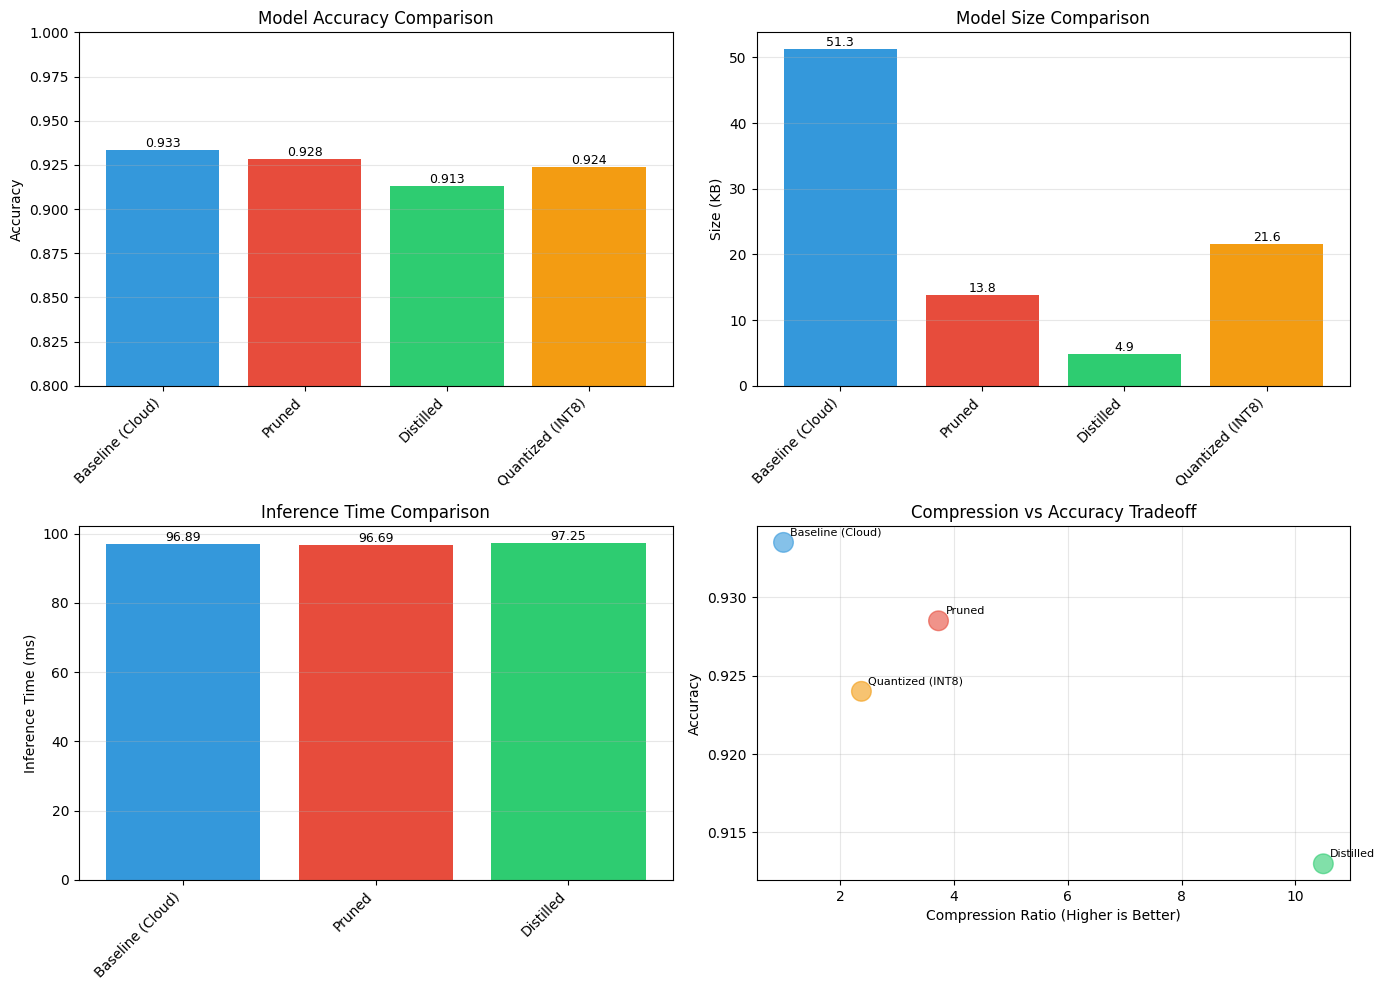

In [48]:
# Create a 2x2 grid of charts to summarize everything at a glance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) Accuracy comparison bar chart
ax1 = axes[0, 0]
bars = ax1.bar(results_df['Model'], results_df['Accuracy'],
               color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylim([0.8, 1.0])  # zoom the y-axis to highlight small differences
ax1.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2) Model size comparison bar chart
ax2 = axes[0, 1]
bars = ax2.bar(results_df['Model'], results_df['Size (KB)'],
               color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
ax2.set_ylabel('Size (KB)')
ax2.set_title('Model Size Comparison')
ax2.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3) Inference time comparison (exclude quantized placeholder for fairness)
ax3 = axes[1, 0]
bars = ax3.bar(results_df['Model'][:3], results_df['Inference Time (ms)'][:3],
               color=['#3498db', '#e74c3c', '#2ecc71'])
ax3.set_ylabel('Inference Time (ms)')
ax3.set_title('Inference Time Comparison')
ax3.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=9)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4) Compression vs accuracy:
# Compute compression ratio = (size of baseline) / (size of each model)
# Higher ratio means bigger size savings compared to baseline.
ax4 = axes[1, 1]
baseline_size = results_df[results_df['Model'] == 'Baseline (Cloud)']['Size (KB)'].values[0]
results_df['Compression Ratio'] = baseline_size / results_df['Size (KB)']
scatter = ax4.scatter(results_df['Compression Ratio'],
                     results_df['Accuracy'],
                     s=200, alpha=0.6,
                     c=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
for idx, row in results_df.iterrows():
    ax4.annotate(row['Model'],
                (row['Compression Ratio'], row['Accuracy']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, ha='left')
ax4.set_xlabel('Compression Ratio (Higher is Better)')
ax4.set_ylabel('Accuracy')
ax4.set_title('Compression vs Accuracy Tradeoff')
ax4.grid(True, alpha=0.3)

# Make the layout neat, save to file for reports, and show the figure
plt.tight_layout()
plt.savefig('edge_model_comparison.png', dpi=300, bbox_inches='tight')
print("\nComparison visualization saved as 'edge_model_comparison.png'")
plt.show()

## PART 6: Edge Deployment Recommendation

In [49]:
print("\n" + "="*70)
print("EDGE DEPLOYMENT RECOMMENDATIONS")
print("="*70)


EDGE DEPLOYMENT RECOMMENDATIONS


In [50]:
def recommend_model(device_type):
    """Pick a model style that fits the device's constraints and needs.
    - Smart Sensor: extremely low memory and energy -> use INT8 quantization.
    - Industrial Controller: moderate compute -> pruning/distillation fits well.
    - Edge AI Hub: high compute resources -> baseline or ensemble model.
    """
    recommendations = {
        'Smart Sensor Node': {
            'model': 'Quantized INT8',
            'reason': 'Requires minimal memory and power, runs efficiently on micro-scale processors',
            'use_cases': 'Remote environmental monitoring, agriculture sensors, battery-powered trackers'
        },
        'Industrial Controller': {
            'model': 'Pruned or Distilled',
            'reason': 'Balances model speed and accuracy for devices with moderate compute power',
            'use_cases': 'Factory automation systems, predictive maintenance units, energy grid controllers'
        },
        'Edge AI Hub': {
            'model': 'Baseline or Ensemble',
            'reason': 'Has sufficient compute and cooling resources to prioritize accuracy over size',
            'use_cases': 'Autonomous drones, smart traffic management, AI-assisted surveillance systems'
        }
    }
    return recommendations.get(device_type, recommendations['Industrial Controller'])

In [51]:

# Print a small guide mapping device types to recommended approaches
for device in ['Microcontroller (MCU)', 'Edge Gateway', 'Edge Server']:
    rec = recommend_model(device)
    print(f"\n{device}:")
    print(f"  Recommended Model: {rec['model']}")
    print(f"  Reason: {rec['reason']}")
    print(f"  Use Cases: {rec['use_cases']}")


Microcontroller (MCU):
  Recommended Model: Pruned or Distilled
  Reason: Balances model speed and accuracy for devices with moderate compute power
  Use Cases: Factory automation systems, predictive maintenance units, energy grid controllers

Edge Gateway:
  Recommended Model: Pruned or Distilled
  Reason: Balances model speed and accuracy for devices with moderate compute power
  Use Cases: Factory automation systems, predictive maintenance units, energy grid controllers

Edge Server:
  Recommended Model: Pruned or Distilled
  Reason: Balances model speed and accuracy for devices with moderate compute power
  Use Cases: Factory automation systems, predictive maintenance units, energy grid controllers


In [52]:
print("\n" + "="*70)
print("SIMULATION COMPLETE")
print("="*70)


SIMULATION COMPLETE


In [53]:
print("\nKey Takeaways:")
# Short and plain-English summary of the main lessons learned
print("1. Quantized models are ideal for smart sensors or other low-power devices where every kilobyte matters.")
print("2. Pruning and distillation both offer strong trade-offs for real-world edge deployments without major accuracy loss.")
print("3. The optimal compression technique depends heavily on where the model runs, not just how accurate it is in the cloud.")
print("4. Even modest compression can significantly lower latency and memory use, which is crucial in distributed IoT systems.")


Key Takeaways:
1. Quantized models are ideal for smart sensors or other low-power devices where every kilobyte matters.
2. Pruning and distillation both offer strong trade-offs for real-world edge deployments without major accuracy loss.
3. The optimal compression technique depends heavily on where the model runs, not just how accurate it is in the cloud.
4. Even modest compression can significantly lower latency and memory use, which is crucial in distributed IoT systems.


## Key Takeaways:
1. Quantized models are ideal for smart sensors or other low-power devices where every kilobyte matters.
2. Pruning and distillation both offer strong trade-offs for real-world edge deployments without major accuracy loss.
3. The optimal compression technique depends heavily on where the model runs, not just how accurate it is in the cloud.
4. Even modest compression can significantly lower latency and memory use, which is crucial in distributed IoT systems.